In [1]:
import math
import numpy as np
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, iirnotch, sosfilt, sosfreqz, lfilter, filtfilt
import biosppy

import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (10,5)

In [2]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    filtered_data_low = butter_lowpass(41.09, sample_rate, 5, data)
    filtered_data_high = butter_highpass(0.48, sample_rate, 2, filtered_data_low)
    #final_filtered_data = moving_average_filter(filtered_data_high, 3)
    return filtered_data_high

In [3]:
# summarize history for loss
def summarize_loss(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [4]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,y_pred), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()

In [5]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
del df["Unnamed: 0"]
df.shape

(21837, 1006)

In [6]:
df = df.loc[df.rhythm_diag != 'OTHER']
df['rhythm_diag'] = df['rhythm_diag'].map(dict(AFIB=1, SR=0))
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)
df=pd.concat([df_minority,maj_class])
df.rhythm_diag.value_counts()
df_sr = df[df.rhythm_diag == 0]
df_sr = df_sr.drop(['ecg_id', 'age', 'sex', 'height',
                    'weight', 'rhythm_diag'], axis=1)
df_sr.reset_index(drop= True ,inplace=True)
df_sr.shape
df_afib = df[df.rhythm_diag == 1]
df_afib = df_afib.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_afib.reset_index(drop=True, inplace=True)
df_afib.shape

(1514, 1000)

In [20]:
X_sr = df_sr.values
X_afib = df_afib.values

In [8]:
X_sr.shape

(1514, 1000)

## Get individuals HeartBeats

In [9]:
def maior_valor_sinal(sinal):
    maior_valor = 0
    for i in range(len(sinal)):
        if(sinal[i] > maior_valor):
            maior_valor = sinal[i]
    return maior_valor

In [10]:
def R_peak_detection(sinal):
    sinal = filter_data(sinal,100)
    indice_aux = 0
    indice_maximo = []
    valor_aux = 0
    valor_maximo = []
    flag_contagem = 0
    indice_temp = 0
    valor_temp = 0
    i = 0
    valor_referencia = maior_valor_sinal(sinal)*0.5
    #print(valor_referencia)
    while i < len(sinal):
        if(sinal[i] > (valor_referencia)):
            indice_aux = i;
            valor_aux = sinal[i];
            if((indice_aux + 5) > len(sinal)):
                pass
            else:
                for x in range(5):
                    if(sinal[indice_aux+x] > valor_aux):
                        indice_temp = indice_aux + x
                        valor_temp = sinal[indice_aux + x]
                        valor_aux = sinal[indice_aux+x]
                    else:
                        flag_contagem = flag_contagem + 1
                indice_maximo.append(indice_temp) 
                valor_maximo.append(valor_temp) 
                if(flag_contagem == 5):
                    indice_maximo.append(i) 
                    valor_maximo.append(sinal[i]) 
                flag_contagem = 0
                indice_temp = 0
                valor_temp = 0
                indice_aux = 0
                valor_aux = 0
                #print(indice_temp+i)
                #print(indice_maximo)
                i = i + 30
        i = i + 1
    contador_zeros = 0
    for j in range (len(indice_maximo)):
        if(indice_maximo[j] == 0):
            contador_zeros = contador_zeros + 1
    for k in range (len(indice_maximo) - contador_zeros):
        if(indice_maximo[k] == 0):
            indice_maximo = np.delete(indice_maximo, k)
    return indice_maximo

In [11]:
def Get_Heartbeats(sinal, frequencia_amostragem, plot = True):
    picos_R = R_peak_detection(sinal)
    heartbeats = []
    indice_min = 0
    indice_max = 0
    zero_points_after = 0
    zero_points_before = 0
    zero_points_aux = 0
    zero_points_aux_1 = 0
    zero_points_aux_2 = 0
    hb = []
    tamanho_sinal = len(sinal)
    tamanho_picos = len(picos_R)-1
    for i in range(1,tamanho_picos):
        difference_peaks_before = picos_R[i]-picos_R[i-1]
        difference_peaks_after = picos_R[i+1]-picos_R[i]
        if((difference_peaks_before >= 25) and (difference_peaks_after >= 35)):
            indice_min = picos_R[i] - (0.25*frequencia_amostragem)
            indice_max = picos_R[i] + (0.35*frequencia_amostragem)
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
        elif((difference_peaks_before) >= 25 and (difference_peaks_after < 35)):
            zero_points_after = 35 - int(difference_peaks_after/2)
            zero_points_aux = np.zeros(zero_points_after)
            indice_min = picos_R[i] - (0.25*frequencia_amostragem)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((sinal[int(indice_min):int(indice_max)],zero_points_aux), axis=None))
        elif((difference_peaks_before < 25) and (difference_peaks_after >= 35)):
            zero_points_before = 25 - int(difference_peaks_before/2)
            zero_points_aux = np.zeros(zero_points_before)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + (0.35*frequencia_amostragem) 
            heartbeats.append(np.concatenate((zero_points_aux, sinal[int(indice_min):int(indice_max)]), axis=None))
        elif((difference_peaks_before < 25) and (difference_peaks_after < 35)):
            zero_points_before = 25 - int(difference_peaks_before/2)
            zero_points_after = 35 - int(difference_peaks_after/2)
            zero_points_aux_1 = np.zeros(zero_points_before)
            zero_points_aux_2 = np.zeros(zero_points_after)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((zero_points_aux_1, sinal[int(indice_min):int(indice_max)], zero_points_aux_2), axis=None))
    heartbeats = np.array(heartbeats)
    #print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

In [12]:
def Get_Complete_Heartbeats(sinal, frequencia_amostragem, plot = True):
    templates = []
    templates_aux = []
    hb = []
    hb_aux = []
    for i in range(len(sinal)): 
        hb_aux = Get_Heartbeats(sinal[i], 100, False)
        for j in range(len(hb_aux)):
            hb.append(hb_aux[j])
    return np.array(hb)

In [21]:
X_sr = Get_Complete_Heartbeats(X_sr, 100, plot = False)
X_sr.shape

(14965, 60)

In [14]:
y_sr = np.zeros(len(X_sr))
y_sr.shape

(14965,)

In [15]:
X_afib = Get_Complete_Heartbeats(X_afib, 100, plot = False)
X_afib.shape

(18567, 60)

In [16]:
y_afib = np.ones(len(X_afib))
y_afib.shape

(18567,)

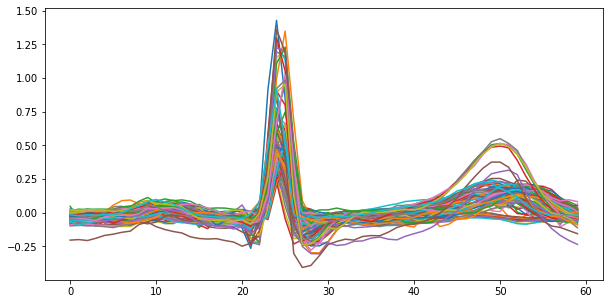

In [17]:
for i in range(100):
    plt.plot(X_sr[i])

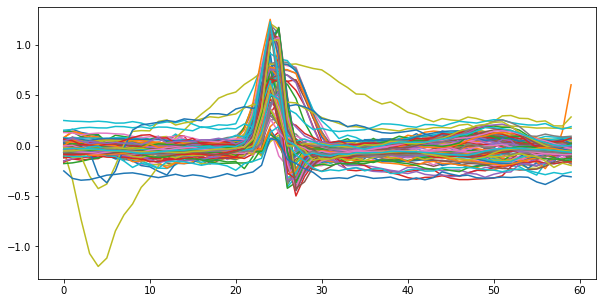

In [18]:
for i in range(100):
    plt.plot(X_afib[i])

In [355]:
X = np.concatenate((X_sr, X_afib), axis=0)
X.shape

(33532, 60)

In [356]:
y = np.concatenate((y_sr, y_afib), axis=0)
y.shape

(33532,)

In [357]:
#saving data
from numpy import save
save('X_25_08.npy', X)
save('y_25_08.npy', y)

In [358]:
# Getting data

X = load('X_25_08.npy')
y = load('y_25_08.npy')

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.20,
                                                    random_state=21)

In [360]:
def normalize_data(Xt):
    Xt_full = []
    for i in range(len(Xt)):
        norm = ((Xt[i] - Xt[i].min())/(Xt[i].max() - Xt[i].min()))
        Xt_full.append(norm)

    Xt_full = np.array(Xt_full)
    print(Xt_full.shape)
    return Xt_full

In [361]:
print (X_train.min(), X_train.max())
X_train = normalize_data(X_train)
print (X_train.min(), X_train.max())

-4.729 2.417
(26825, 60)
0.0 1.0


In [362]:
print (X_test.min(), X_test.max())
X_test = normalize_data(X_test)
print (X_test.min(), X_test.max())

-1.434 2.553
(6707, 60)
0.0 1.0


In [363]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

print(X_train.shape, X_test.shape)

(26825, 60, 1) (6707, 60, 1)


In [364]:
samples, features, depht = X_train.shape
print(samples, features, depht)

26825 60 1


In [324]:
import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [325]:
def group_layer(model):
    model.add(
        Conv1D(8,
               kernel_size=7,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(8,
               kernel_size=7,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [365]:
def group_layer(model):
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [366]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [367]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 60, 32)            192       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 32)            5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 28, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 32)            5152      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 28, 32)            5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 32)           

In [368]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [369]:
EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
671/671 [==============================] - 9s 10ms/step - loss: 0.4953 - accuracy: 0.7627 - val_loss: 0.3367 - val_accuracy: 0.8604
Epoch 2/100
671/671 [==============================] - 7s 10ms/step - loss: 0.3747 - accuracy: 0.8488 - val_loss: 0.3193 - val_accuracy: 0.8729
Epoch 3/100
671/671 [==============================] - 7s 10ms/step - loss: 0.3464 - accuracy: 0.8621 - val_loss: 0.3365 - val_accuracy: 0.8596
Epoch 4/100
671/671 [==============================] - 9s 13ms/step - loss: 0.3309 - accuracy: 0.8691 - val_loss: 0.3517 - val_accuracy: 0.8460
Epoch 5/100
671/671 [==============================] - 8s 12ms/step - loss: 0.3233 - accuracy: 0.8721 - val_loss: 0.2926 - val_accuracy: 0.8800
Epoch 6/100
671/671 [==============================] - 7s 11ms/step - loss: 0.3151 - accuracy: 0.8748 - val_loss: 0.2956 - val_accuracy: 0.8818
Epoch 7/100
671/671 [==============================] - 7s 11ms/step - loss: 0.3051 - accuracy: 0.8798 - val_loss: 0.2756 - val_accuracy:

In [326]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 8)             64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 8)             456       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 8)             0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 8)             0         
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 900       
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0

In [328]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

In [329]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
671/671 [==============================] - 9s 4ms/step - loss: 0.5894 - accuracy: 0.6857 - val_loss: 0.4256 - val_accuracy: 0.8382
Epoch 2/100
671/671 [==============================] - 2s 3ms/step - loss: 0.4436 - accuracy: 0.8123 - val_loss: 0.3726 - val_accuracy: 0.8520
Epoch 3/100
671/671 [==============================] - 2s 3ms/step - loss: 0.4072 - accuracy: 0.8257 - val_loss: 0.3453 - val_accuracy: 0.8617
Epoch 4/100
671/671 [==============================] - 2s 4ms/step - loss: 0.3869 - accuracy: 0.8363 - val_loss: 0.3282 - val_accuracy: 0.8669
Epoch 5/100
671/671 [==============================] - 2s 4ms/step - loss: 0.3755 - accuracy: 0.8397 - val_loss: 0.3252 - val_accuracy: 0.8677
Epoch 6/100
671/671 [==============================] - 2s 3ms/step - loss: 0.3713 - accuracy: 0.8404 - val_loss: 0.3108 - val_accuracy: 0.8725
Epoch 7/100
671/671 [==============================] - 2s 3ms/step - loss: 0.3613 - accuracy: 0.8479 - val_loss: 0.3122 - val_accuracy: 0.8768

Model Accuraccy:  0.89


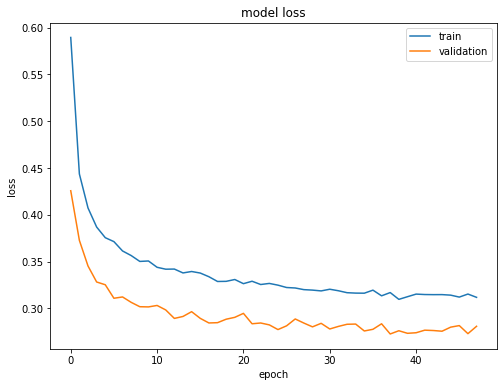

In [330]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)